<a href="https://colab.research.google.com/github/gani88/CrackDetectionInPainting/blob/main/CrackDetectionPaintingV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Painting Crack Detection using CNN Model
This model will trying to detect a crack in painting. CNN can work with detection and classification, the detected painting will classified to 2 class : Crack and NonCrack. Hence, the dataset also consist 2 label : Crack and NonCrack.

In [ ]:
# Unzip File Dataset
import zipfile

local_zip = '/content/PaintingDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

## Extract the Dataset

In [2]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/PaintingDataset.zip'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')  


Mounted at /content/drive


In [3]:
import os

base_dir = '/content/data/Painting Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Training'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Validation'))

Contents of base directory:
['Validation', 'Training']

Contents of train directory:
['Crack', 'NonCrack']

Contents of validation directory:
['Crack', 'NonCrack']


In [4]:
import os

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with training crack and noncrack images pictures
train_noncrack_dir = os.path.join(train_dir, 'NonCrack')
train_crack_dir = os.path.join(train_dir, 'Crack')

# Directory with validation crack and noncrack images pictures
validation_noncrack_dir = os.path.join(validation_dir, 'NonCrack')
validation_crack_dir = os.path.join(validation_dir, 'Crack')

In [5]:
train_noncrack_fnames = os.listdir( train_noncrack_dir )
train_crack_fnames = os.listdir( train_crack_dir )

print("Non Crack Painting : ", train_noncrack_fnames[:10])
print("Crack Painting : ", train_crack_fnames[:10])

Non Crack Painting :  ['0248.jpg', '0143.jpg', '0164.jpg', '0006.jpg', '0223.jpg', '0220.jpg', '0384.jpg', '0221.jpg', '0056.jpg', '0386.jpg']
Crack Painting :  ['3rules1.jpg', '33cardel.jpg', '10prato.jpg', 'marymagd.jpg', 'dante1.jpg', '187madon.jpg', '4deposit.jpg', 'creatiox.jpg', '37entom.jpg', '5peter6.jpg']


In [6]:
print('total training NonCrack images :', len(os.listdir(      train_noncrack_dir ) ))
print('total training Crack images :', len(os.listdir(      train_crack_dir ) ))

print('total validation NonCrack images :', len(os.listdir( validation_noncrack_dir ) ))
print('total validation Crack images :', len(os.listdir( validation_crack_dir ) ))

total training NonCrack images : 240
total training Crack images : 240
total validation NonCrack images : 60
total validation Crack images : 60


## Display & Check the Dataset

In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

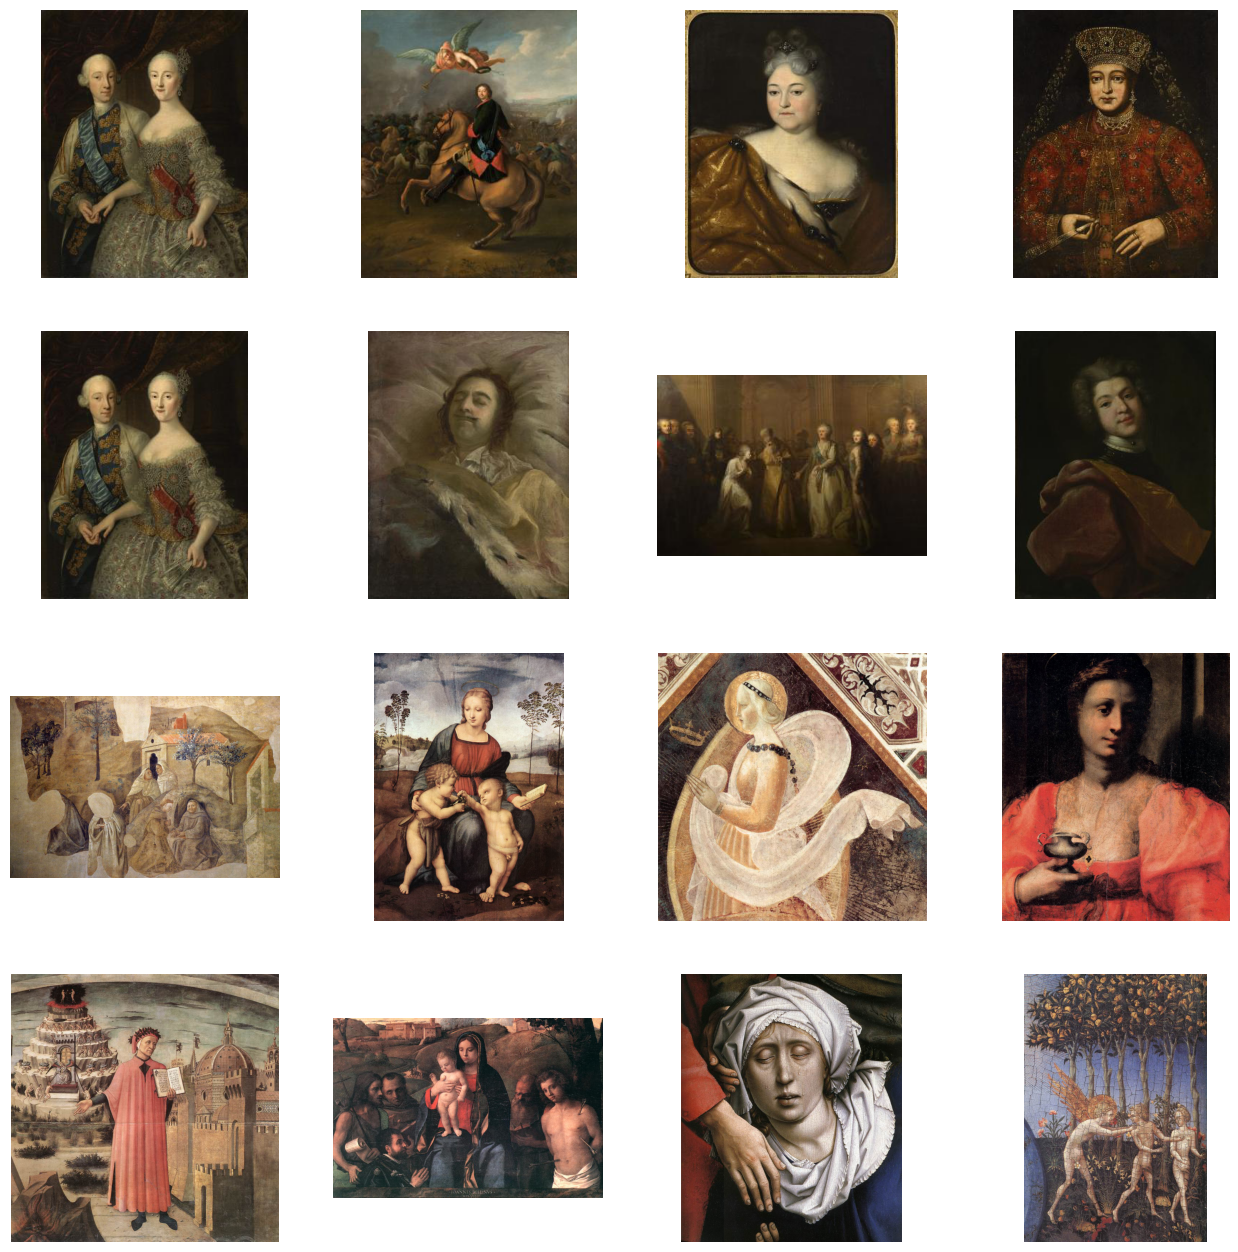

In [8]:

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_noncrack_pix = [os.path.join(train_noncrack_dir, fname) 
                for fname in train_noncrack_fnames[ pic_index-8:pic_index] 
               ]

next_crack_pix = [os.path.join(train_crack_dir, fname) 
                for fname in train_crack_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_noncrack_pix+next_crack_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data Processing / Preprocessing Data

In [9]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale 1/255
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the custom preprocessing function
def custom_preprocessing(img):
    # Define the kernel size for the top-hat transform
    kernel_size = 10
    # Define the structuring element for the top-hat transform
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the top-hat transform to enhance the contrast of the cracks
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    # Define the kernel size for the dilation operation
    kernel_size = 3
    # Define the structuring element for the dilation operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    # Perform the dilation operation to expand the boundaries of the cracks
    dilated = cv2.dilate(tophat, kernel)
    # Return the preprocessed image
    return dilated

# Define the data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing
)

# Load the training and validation data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(250, 250),
    batch_size=20,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(250, 250),
    batch_size=20,
    class_mode='binary'
)


Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# The Model

In [10]:
# Model
import tensorflow as tf

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('noncrack') and 1 for the other ('crack')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_addons as tfa

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tfa.metrics.F1Score(1)])

In [13]:
history = model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
            verbose=1
            )

Epoch 1/10
24/24 [==============================] - 21s 315ms/step - loss: 0.6413 - accuracy: 0.6896 - val_loss: 0.4628 - val_accuracy: 0.8583
Epoch 2/10
24/24 [==============================] - 5s 204ms/step - loss: 0.3039 - accuracy: 0.8875 - val_loss: 0.1421 - val_accuracy: 0.9500
Epoch 3/10
24/24 [==============================] - 7s 304ms/step - loss: 0.2563 - accuracy: 0.9104 - val_loss: 0.1125 - val_accuracy: 0.9917
Epoch 4/10
24/24 [==============================] - 5s 198ms/step - loss: 0.1340 - accuracy: 0.9667 - val_loss: 0.0731 - val_accuracy: 0.9667
Epoch 5/10
24/24 [==============================] - 5s 214ms/step - loss: 0.1253 - accuracy: 0.9542 - val_loss: 0.1495 - val_accuracy: 0.9667
Epoch 6/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0955 - accuracy: 0.9667 - val_loss: 0.0489 - val_accuracy: 0.9917
Epoch 7/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0692 - accuracy: 0.9688 - val_loss: 1.3040 - val_accuracy: 0.6333
Epoch

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
24/24 [==============================] - 9s 249ms/step - loss: 0.0139 - recall_7: 0.9958 - false_positives_7: 2.0000 - false_negatives_7: 1.0000 - precision_7: 0.9917 - f1_score: 0.6946 - val_loss: 0.0312 - val_recall_7: 0.9833 - val_false_positives_7: 0.0000e+00 - val_false_negatives_7: 1.0000 - val_precision_7: 1.0000 - val_f1_score: 0.7595
Epoch 2/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0544 - recall_7: 0.9750 - false_positives_7: 2.0000 - false_negatives_7: 6.0000 - precision_7: 0.9915 - f1_score: 0.7007 - val_loss: 0.0193 - val_recall_7: 1.0000 - val_false_positives_7: 2.0000 - val_false_negatives_7: 0.0000e+00 - val_precision_7: 0.9677 - val_f1_score: 0.6742
Epoch 3/10
24/24 [==============================] - 5s 201ms/step - loss: 0.0054 - recall_7: 1.0000 - false_positives_7: 0.0000e+00 - false_negatives_7: 0.0000e+00 - precision_7: 1.0000 - f1_score: 0.6667 - val_loss: 0.0159 - val_recall_7: 1.0000 - val_false_positives_7: 0.0000e+00 - val

In [ ]:
# Evaluate metrics

# Evaluate the model on the validation set
val_loss, val_recall, val_false_pos, val_false_neg, val_precision, val_f1_score = model.evaluate(validation_generator, steps=len(validation_generator))

# Print the evaluation metrics
print('Validation loss: {:.3f}'.format(val_loss))
print('Validation recall: {:.3f}'.format(val_recall))
print('Validation false positive rate: {:.3f}'.format(val_false_pos))
print('Validation false negative rate: {:.3f}'.format(val_false_neg))
print('Validation precision: {:.3f}'.format(val_precision))
print('Validation F1 score: {:.3f}'.format(val_f1_score[0]))

# Predict on the validation set and generate a classification report
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred))

6/6 [==============================] - 1s 155ms/step - loss: 0.0058 - recall_7: 1.0000 - false_positives_7: 0.0000e+00 - false_negatives_7: 0.0000e+00 - precision_7: 1.0000 - f1_score: 0.7059
Validation loss: 0.006
Validation recall: 1.000
Validation false positive rate: 0.000
Validation false negative rate: 0.000
Validation precision: 1.000
Validation F1 score: 0.706
6/6 [==============================] - 1s 152ms/step
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        60
           1       0.50      0.50      0.50        60

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.50       120
weighted avg       0.50      0.50      0.50       120



In [ ]:
# Prediksi lukisan memiliki retakan atau tidak.
## Pinpoint untuk tahap selanjutnya dalam melakukan patching pada lukisan retak
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array


if not os.path.exists('inputs/upload'):
    os.makedirs('inputs/upload')

uploaded = files.upload()

for fn in uploaded.keys():
  
  # Load and display the image
  img = load_img('/content/' + fn, target_size=(150, 150))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # Predict the class label
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  # Print the prediction result
  if classes[0] > 0.5:
    print(fn + " is a non-crack")
  else:
    print(fn + " is a crack")

  save_path = os.path.join('inputs/upload', fn)
  img.save(save_path)


Text(0.5, 1.0, 'Training and validation loss')

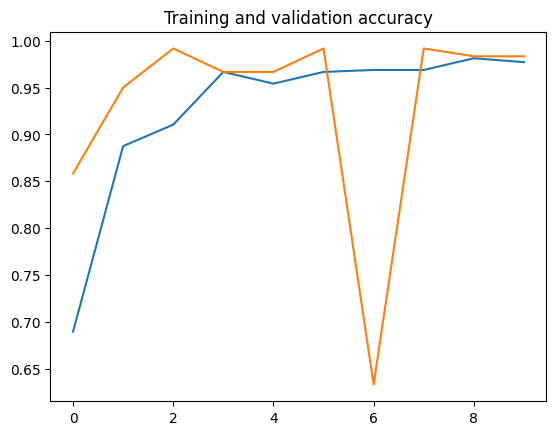

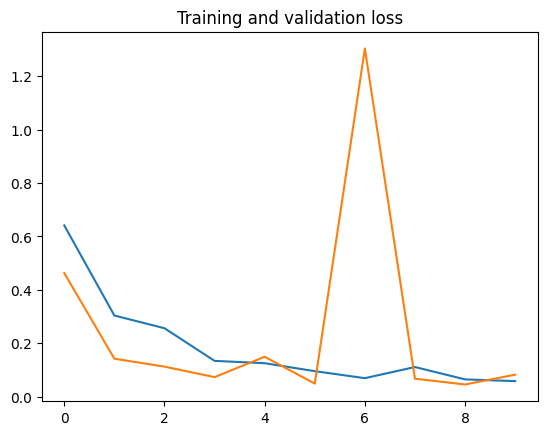

In [16]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
model.save('my_model.h5')

# Next Step : Still in Experimental. ( Make Restoration using GANs and the library)

In [17]:
%cd /content
!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 523, done.
remote: Total 523 (delta 0), reused 0 (delta 0), pack-reused 523
Receiving objects: 100% (523/523), 5.39 MiB | 11.41 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/GFPGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 24.2 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214823 sha256=50abe74f47221c6b2c8fcf702371b606bc0a6b58c72dbd12ecfd8007a94840a1
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=95b1542da2f6ac64c731d688098ed3958c2612a00640f7343c22a083084b0def
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
     

In [18]:
# upload 
import os
from google.colab import files
import shutil

upload_folder = 'inputs/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

# upload 
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving 0monalis.jpg to 0monalis.jpg
move 0monalis.jpg to inputs/upload/0monalis.jpg


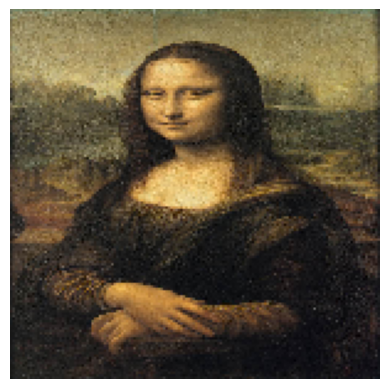

1/1 [==============================] - 0s 48ms/step
0monalis.jpg is a crack


In [21]:
# Prediksi lukisan memiliki retakan atau tidak.
## Pinpoint untuk tahap selanjutnya dalam melakukan patching pada lukisan retak
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

folder_path = '/content/GFPGAN/inputs/upload'  # Path to the folder containing the images

# Get a list of files in the folder
image_files = os.listdir(folder_path)

for filename in image_files:
    # Construct the full path to the image
    image_path = os.path.join(folder_path, filename)
    
    # Load and display the image
    img = load_img(image_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict the class label
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # Print the prediction result
    if classes[0] > 0.5:
        print(filename + " is a non-crack")
    else:
        print(filename + " is a crack")


In [22]:
!rm -rf results
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth" to /usr/local/lib/python3.10/dist-packages/weights/RealESRGAN_x2plus.pth

100% 64.0M/64.0M [00:00<00:00, 310MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the fu

## Output Image

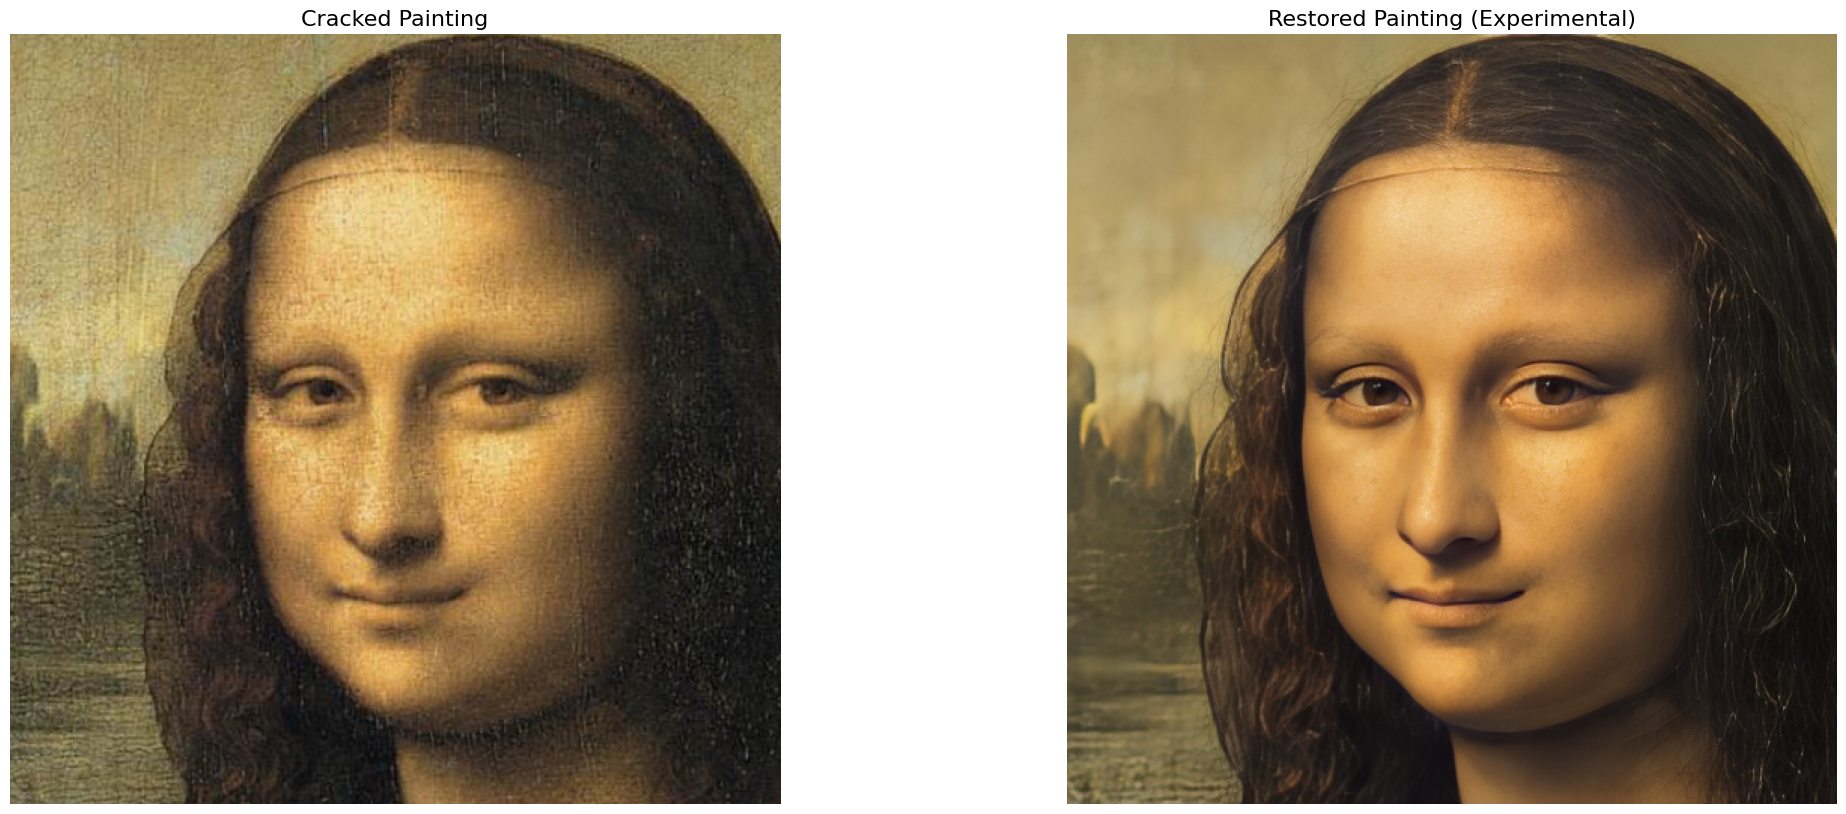

In [23]:
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1) 
  plt.title('Cracked Painting', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Restored Painting (Experimental)', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'results/cropped_faces'
result_folder = 'results/restored_faces'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)